---
* ### Import as libs  
---

In [382]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import control as ctl
from carima import generate_matrices, get_G, get_F

---
* ### Função para plotar em grade
---

In [383]:
def plot(time, y_matriz, title, cols_name, time_aux=None, y_matriz_aux=None):
    n_row, n_col = len(y_matriz), len(y_matriz[0])
    
    fig, axs = plt.subplots(n_row, n_col, figsize=(11, 7), sharex=True)

    # nome das colunas 
    for j in range(n_col):
        axs[0, j].set_title(f'{title} - {cols_name[j]}')

    for i in range(n_row):
        for j in range(n_col):
            offset_x = 0
            if y_matriz_aux is not None and time_aux is not None:
                # plota as linhas auxiliares
                dic_aux = y_matriz_aux[i][j]
                offset_x = len(dic_aux[0])
                axs[i, j].plot(time_aux[:offset_x], dic_aux[0], label=dic_aux[1], color=dic_aux[2], marker=dic_aux[3])

                # tranforma em dt
                dt = time[1] - time[0]
                offset_x = offset_x * dt

            # plota as linhas
            dic = y_matriz[i][j]
            axs[i, j].plot(time + offset_x, dic[0], label=dic[1], color=dic[2], marker=dic[3])

            # configurações do gráfico
            axs[i, j].grid()
            axs[i, j].legend()
            #axs[i, j].set_ylim(-6, 6)
            #axs[i, j].set_ylabel(f'Output {i+1}')
    
    plt.tight_layout()
    plt.show()

def print_tf(sys):
    # printa só as ultimas 3 linhas 
    text = sys.__str__().splitlines()
    for line in text[-3:]:
        print(line)

# Converter cada canal SymPy -> control.TransferFunction SISO (em s)
def sympy_to_tf(expr_s, s_symbol):
    """Converte uma função racional em s (SymPy) -> control.TransferFunction SISO."""
    num, den = sp.fraction(sp.together(sp.simplify(expr_s)))
    num_poly = sp.Poly(num, s_symbol)
    den_poly = sp.Poly(den, s_symbol)

    # Coeficientes do maior para o menor grau
    num_cf = [float(c) for c in num_poly.all_coeffs()]
    den_cf = [float(c) for c in den_poly.all_coeffs()]
    return ctl.tf(num_cf, den_cf)

---
* ### Constantes
---

In [384]:
n_node = 6

# array de massas 
coef_m = 2.5
ATMD_m = 2.5
m_arr = [i * coef_m if i < n_node +1 else ATMD_m for i in range(1, n_node +2)]

# constantes de amortecimento
coef_c = 0.3
ATMD_c = 0.1
c_arr = [i * coef_c if i < n_node +1 else ATMD_c for i in range(1, n_node +2)]

# constantes de rigidez
coef_k = 0.3
ATMD_k = 1.0
k_arr = [i * coef_k if i < n_node +1 else ATMD_k for i in range(1, n_node +2)]

# modal participation factor
beta_0 = 0.33

print(c_arr)

[0.3, 0.6, 0.8999999999999999, 1.2, 1.5, 1.7999999999999998, 0.1]


---
* ### Matrizes
---

In [385]:
# Matriz de massa
m_matriz = sp.diag(*m_arr)

# Matriz de amortecimento
c_arr_desl = [c_arr[i] + c_arr[i+1] if i < len(c_arr) - 1 else c_arr[i] for i in range(len(c_arr))]
c_matriz = sp.diag(*c_arr_desl)
for i in range(len(c_arr)-1):
    c_matriz[i, i+1] = -c_arr[i+1]
    c_matriz[i+1, i] = -c_arr[i+1]

# Matriz de rigidez
k_arr_desl = [k_arr[i] + k_arr[i+1] if i < len(k_arr) - 1 else k_arr[i] for i in range(len(k_arr))]
k_matriz = sp.diag(*k_arr_desl)
for i in range(len(k_arr)-1):
    k_matriz[i, i+1] = -k_arr[i+1]
    k_matriz[i+1, i] = -k_arr[i+1]

# Matriz da entrada u [0 0 0 ... -1 1].T 
B = sp.Matrix([[0] for _ in range(n_node - 1)] + [[-1], [1]])

# Matriz da entrada do deslocamento do solo [beta_0*m0 beta_1*0 ... beta_n*mn m_ATMD].T
beta_coef = 0.33
C = sp.Matrix([[m_arr[0] * beta_coef * i] for i in range(1, n_node+1)] + [[m_arr[-1]]])

---
* ### Funções de transferência
---

In [386]:
t, s = sp.symbols('t s', positive=True, real=True)

# M*x'' + N*x' + K*x = B*u + C*q
# (M*s**2 + N*s + K)*X = B*U + C*Q
# AX = BU + CQ
A = m_matriz*s**2 + c_matriz*s + k_matriz

# Função de transferência do sistema
H_U = (A.inv() * B)
H_Q = (A.inv() * C)

# Simplificação das expressões
H_U = sp.simplify(H_U)
H_Q = sp.simplify(H_Q)

# matriz de transferência do sistema 
H = sp.Matrix.hstack(H_U, H_Q)

---
* ### Matriz de TF - sistema continuo
---

In [387]:
H_s_matriz = [[] for _ in range(H.rows)]
for i in range(H.rows):
    for j in range(H.cols):
        H_s_matriz[i].append(sympy_to_tf(H[i,j], s))

for hi in H_s_matriz:
    for hj in hi:
        print_tf(hj)
        print()

                                                                         -4.374 s^7 - 21.87 s^6 - 43.74 s^5 - 43.74 s^4 - 21.87 s^3 - 4.374 s^2
  --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  4.395e+05 s^14 + 7.21e+05 s^13 + 1.35e+06 s^12 + 1.308e+06 s^11 + 1.306e+06 s^10 + 8.369e+05 s^9 + 5.439e+05 s^8 + 2.323e+05 s^7 + 1.027e+05 s^6 + 2.72e+04 s^5 + 8135 s^4 + 1054 s^3 + 212.5 s^2 + 3.202 s + 0.5249

                1.45e+05 s^12 + 2.205e+05 s^11 + 4.059e+05 s^10 + 3.697e+05 s^9 + 3.604e+05 s^8 + 2.166e+05 s^7 + 1.365e+05 s^6 + 5.385e+04 s^5 + 2.293e+04 s^4 + 5446 s^3 + 1583 s^2 + 176.9 s + 34.69
  --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  4.395e+0

---
* ### Matriz de TF - sistema discreto
---

In [ ]:
# tempo de amostragem 
T = 2.0

H_z_matriz = [[] for _ in range(H.rows)]

# converter cada canal para TF discreto
for i in range(H.rows):
    for j in range(H.cols):
        H_z_matriz[i].append(ctl.sample_system(H_s_matriz[i][j], T, method="zoh"))

# print
for hi in H_z_matriz:
    for hj in hi:
        print_tf(hj)
        print()

  -5.555e-08 z^13 - 9.018e-06 z^12 - 9.817e-05 z^11 - 3.359e-05 z^10 + 0.0004256 z^9 - 0.0001857 z^8 - 0.0002691 z^7 + 0.0002097 z^6 - 3.202e-05 z^5 - 1.189e-05 z^4 + 4.865e-06 z^3 - 5.83e-07 z^2 + 1.345e-08 z + 1.262e-09
  ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                         z^14 - 8.741 z^13 + 37.13 z^12 - 101.5 z^11 + 199.1 z^10 - 296.4 z^9 + 345.4 z^8 - 319.9 z^7 + 236.9 z^6 - 139.8 z^5 + 64.87 z^4 - 23.03 z^3 + 5.943 z^2 - 1.006 z + 0.08535

     0.345 z^13 - 2.099 z^12 + 6.122 z^11 - 10.93 z^10 + 12.55 z^9 - 8.161 z^8 - 0.2149 z^7 + 7.224 z^6 - 9.236 z^5 + 7.008 z^4 - 3.628 z^3 + 1.288 z^2 - 0.291 z + 0.03301
  ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  z^14 - 8

---
* ### Plot - resposta ao impulso
---

In [389]:
# dados pra simular
start = 0
stop = 150
step = T
time = np.arange(start, stop, step)

cols_name = ['u', 'q']

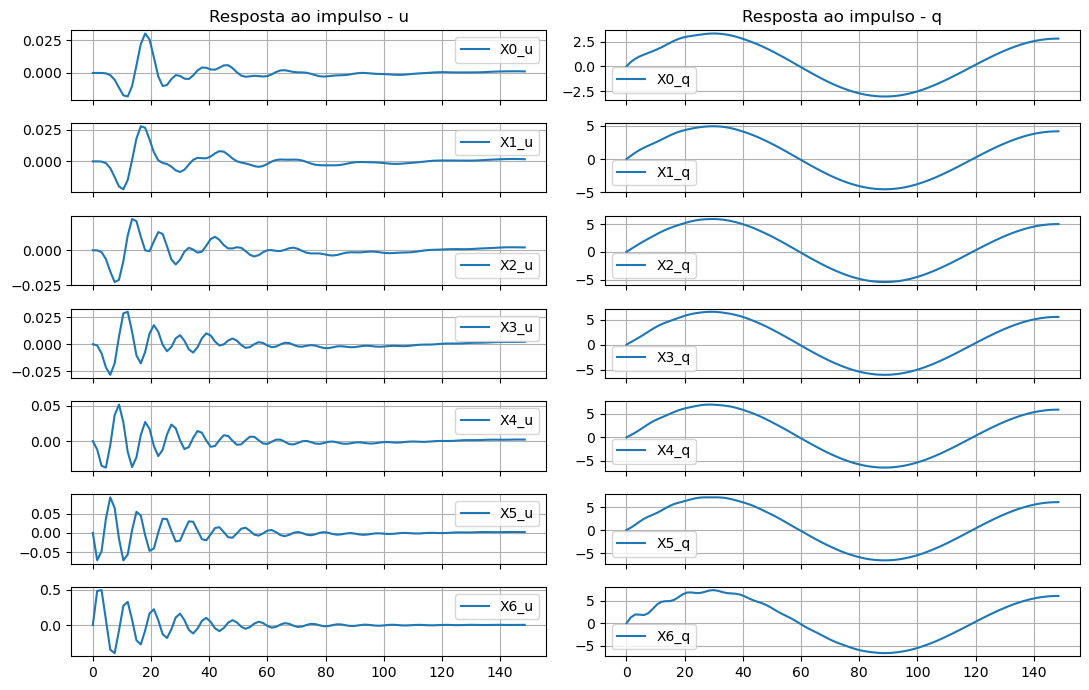

In [390]:
# plot a resposta ao impulso
y_matriz_out = [[] for _ in range(H.rows)]

for i in range(H.rows):
    for j in range(H.cols):
        t_out, y_out = ctl.impulse_response(H_s_matriz[i][j], T=time)
        y_plot = [y_out.tolist(), "X{}_{}".format(i, cols_name[j]), 'C0', None]
        y_matriz_out[i].append(y_plot)

# plot 
plot(time, y_matriz_out, "Resposta ao impulso", cols_name)

---
* ### Plot - resposta ao impulso
---

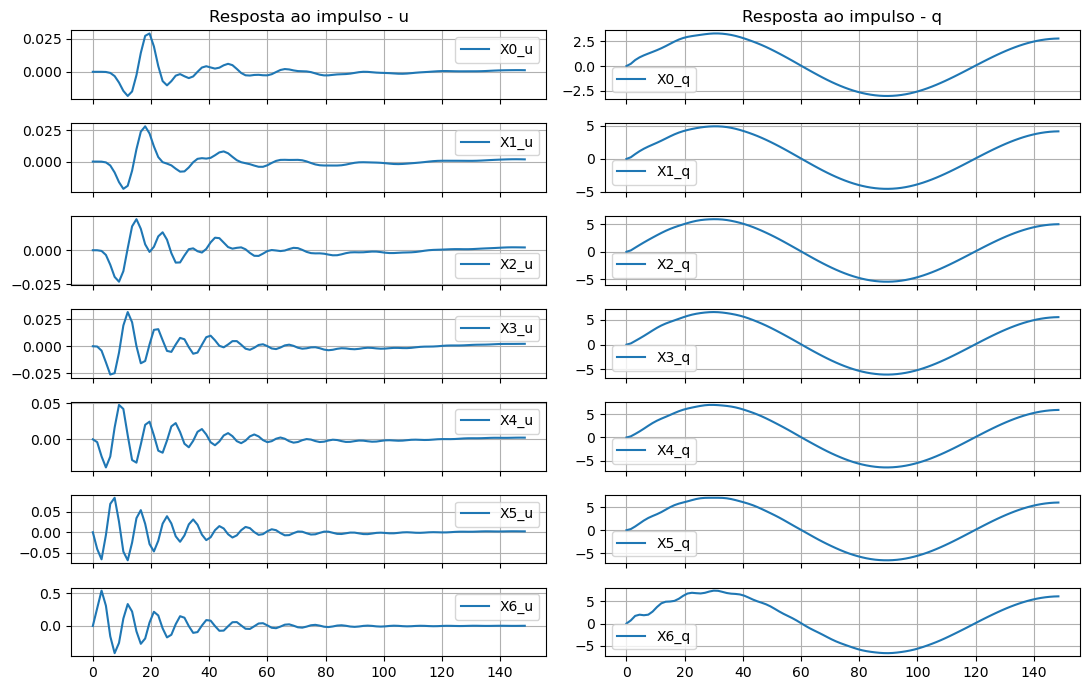

In [391]:
# plot a resposta ao impulso
y_matriz_out = [[] for _ in range(H.rows)]

for i in range(H.rows):
    for j in range(H.cols):
        t_out, y_out = ctl.impulse_response(H_z_matriz[i][j], T=time)
        y_plot = [y_out.tolist(), "X{}_{}".format(i, cols_name[j]), 'C0', None]
        y_matriz_out[i].append(y_plot)

# plot 
plot(time, y_matriz_out, "Resposta ao impulso", cols_name)

---
* ### Predição - usando CARIMA
---

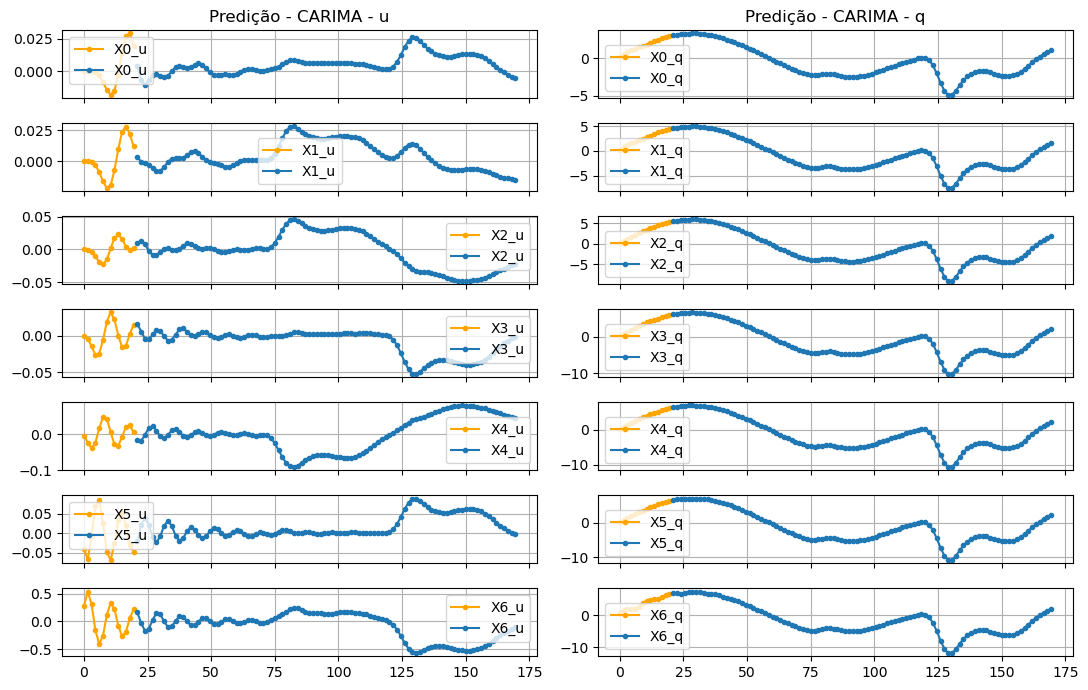

In [392]:
y_pred = [[] for _ in range(H.rows)]
y_pass = [[] for _ in range(H.rows)]

for i in range(H.rows):
    for j in range(H.cols):
        F = get_F(H_z_matriz[i][j], len(time))
        # pegar a condição inicial 
        y_in = y_matriz_out[i][j][0][1:F.shape[1]+1][::-1]

        # calcula a resposta livre
        y_out = F @ y_in

        # salva pra plotar
        y_plot0 = [y_out.tolist(), "X{}_{}".format(i, cols_name[j]), 'C0', '.']
        y_plot1 = [y_in[::-1], "X{}_{}".format(i, cols_name[j]), 'orange', '.']
        y_pred[i].append(y_plot0)
        y_pass[i].append(y_plot1)

# plot 
plot(time, y_pred, "Predição - CARIMA", cols_name, time_aux=time, y_matriz_aux=y_pass)

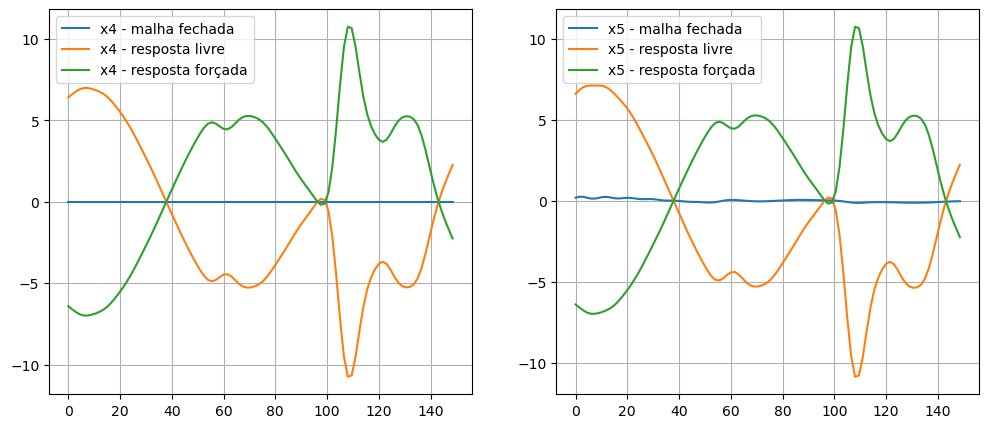

In [393]:
# ponderação nas ações de controle
alpha = 0.0
N_y = len(time)
N_u = len(time)

R = np.eye(N_u) * alpha
Q = np.eye(N_u) # monovariavel - delta é fixo = 1

F, G = generate_matrices(H_z_matriz[n_node-1][0], N_u, N_y)

# solution of quadratic problem
K = np.linalg.inv(G.T @ G + R) @ G.T

# solucao do sistema (free para a massa da nacele)
x0_free = y_pred[n_node-2][1][0]
u_opt = -K @ x0_free

# calcula a resposta forçada
x0_forced = G @ u_opt

# resposta total 
x0 = x0_free + x0_forced

x1_free = y_pred[n_node-1][1][0]
x1_forced = G @ u_opt
x1 = x1_free + x1_forced

# plot 
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(time, x0, label='x{} - malha fechada'.format(n_node-2))
ax[0].plot(time, x0_free, label='x{} - resposta livre'.format(n_node-2))
ax[0].plot(time, x0_forced, label='x{} - resposta forçada'.format(n_node-2))

ax[1].plot(time, x1, label='x{} - malha fechada'.format(n_node-1))
ax[1].plot(time, x1_free, label='x{} - resposta livre'.format(n_node-1))
ax[1].plot(time, x1_forced, label='x{} - resposta forçada'.format(n_node-1))

for a in ax:
    a.grid()
    a.legend()
plt.show()
